In [1]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import keras
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Segmentation Models: using `tf.keras` framework.


In [3]:
import glob
import cv2
import os
images = glob.glob("/kaggle/input/kidney-segmentation-dataset/2d segmentation dataset/2d segmentation dataset/images/*.png")
images.sort()
masks = glob.glob("/kaggle/input/kidney-segmentation-dataset/2d segmentation dataset/2d segmentation dataset/masks/*.png")
masks.sort()

In [4]:
import os
image=[]
mask=[]
for x,y in zip(images,masks):
  im=cv2.imread(x,cv2.IMREAD_COLOR)
  im=cv2.resize(im,(128,128))
  im=im/255
  image.append(im)
  ma=cv2.imread(y,cv2.IMREAD_GRAYSCALE)
  ma=cv2.resize(ma,(128,128),interpolation=cv2.INTER_NEAREST)
  ma=ma/255
  ma=np.expand_dims(ma,axis=-1)
  mask.append(ma)

In [5]:
img_array=np.array(image)
mask_array=np.array(mask)
mask_array=mask_array.astype(np.float32)
print(mask_array.shape)

(2027, 128, 128, 1)


In [6]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
a,n,h, w = mask_array.shape
train_masks_reshaped = mask_array.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(a,n, h, w)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
from tensorflow.keras.utils import to_categorical
mask_array=to_categorical(train_masks_encoded_original_shape,num_classes=5)

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(img_array,mask_array,test_size=0.20)
print(y_train.dtype,y_test.dtype)

float32 float32


In [9]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1621, 128, 128, 3),
 (406, 128, 128, 3),
 (1621, 128, 128, 5),
 (406, 128, 128, 5))

In [10]:
import segmentation_models as sm
from segmentation_models import FPN
from segmentation_models import get_preprocessing
from tensorflow.keras.utils import plot_model
sm.set_framework('tf.keras')
sm.framework()
BACKBONE = 'seresnet34'

preprocess_input = get_preprocessing(BACKBONE)
model = FPN(BACKBONE, encoder_weights='imagenet',input_shape=(128,128,3),activation='softmax',classes=5)
#plot_model(model)

86315168/86315168 [==============================] - 1s 0us/step


In [11]:
model.compile(optimizer='adam',loss=sm.losses.DiceLoss(),metrics = ['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC(),sm.metrics.IOUScore(),sm.metrics.FScore()])

In [12]:
csv=tf.keras.callbacks.CSVLogger('seres-FPN.csv')
history=model.fit(x_train, 
          y_train,
          batch_size=2, 
          epochs=80,
          validation_data=(x_test, y_test),callbacks=csv)

Epoch 1/80
811/811 [==============================] - 96s 61ms/step - loss: 0.4994 - accuracy: 0.8124 - recall: 0.8108 - precision: 0.8154 - auc: 0.9124 - iou_score: 0.3973 - f1-score: 0.5007 - val_loss: 0.7337 - val_accuracy: 0.7145 - val_recall: 0.7133 - val_precision: 0.7156 - val_auc: 0.8448 - val_iou_score: 0.2124 - val_f1-score: 0.2663
Epoch 2/80
811/811 [==============================] - 46s 57ms/step - loss: 0.2510 - accuracy: 0.9262 - recall: 0.9260 - precision: 0.9264 - auc: 0.9666 - iou_score: 0.6371 - f1-score: 0.7490 - val_loss: 0.2516 - val_accuracy: 0.9247 - val_recall: 0.9246 - val_precision: 0.9249 - val_auc: 0.9652 - val_iou_score: 0.6377 - val_f1-score: 0.7484
Epoch 3/80
811/811 [==============================] - 46s 56ms/step - loss: 0.1804 - accuracy: 0.9496 - recall: 0.9495 - precision: 0.9497 - auc: 0.9777 - iou_score: 0.7208 - f1-score: 0.8196 - val_loss: 0.2284 - val_accuracy: 0.9368 - val_recall: 0.9368 - val_precision: 0.9370 - val_auc: 0.9706 - val_iou_score

In [13]:
x_test=x_test.astype(np.float32)
y_test=y_test.astype(np.float32)

In [14]:
model.evaluate(x_test,y_test)

13/13 [==============================] - 6s 188ms/step - loss: 0.0586 - accuracy: 0.9845 - recall: 0.9845 - precision: 0.9845 - auc: 0.9920 - iou_score: 0.8928 - f1-score: 0.9412


[0.05860695242881775,
 0.9845456480979919,
 0.984544575214386,
 0.9845482707023621,
 0.9919707775115967,
 0.8927596211433411,
 0.9412464499473572]

51/51 [==============================] - 4s 77ms/step


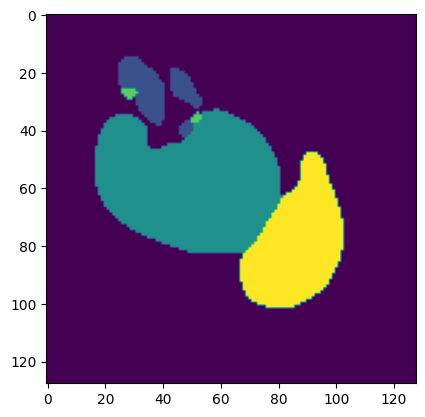

In [135]:
test_preds = model.predict(x_train)
preds_train_thresh = (np.argmax(test_preds,axis=-1)).astype(np.uint8)
y_train = (np.argmax(y_train,axis=-1)).astype(np.uint8)
test_img = preds_test_thresh[0, :, :]
plt.imshow(test_img)

/tmp/ipykernel_27/964660089.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)
/tmp/ipykernel_27/964660089.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,10))


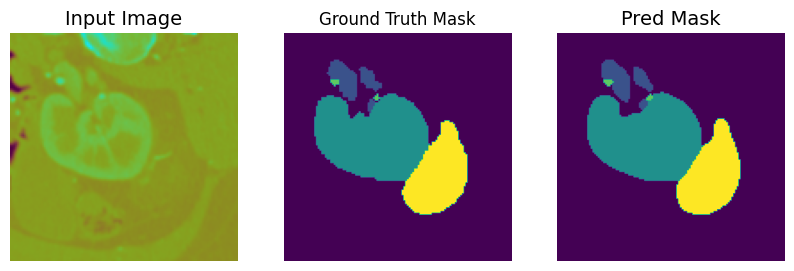

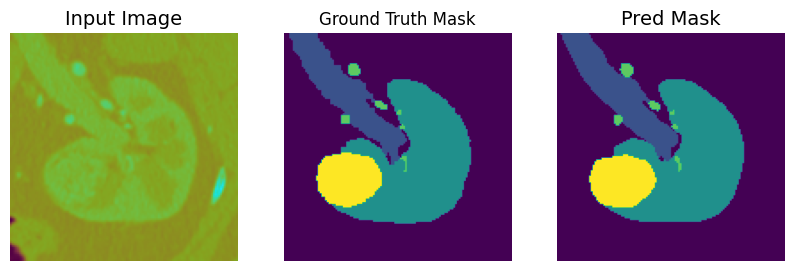

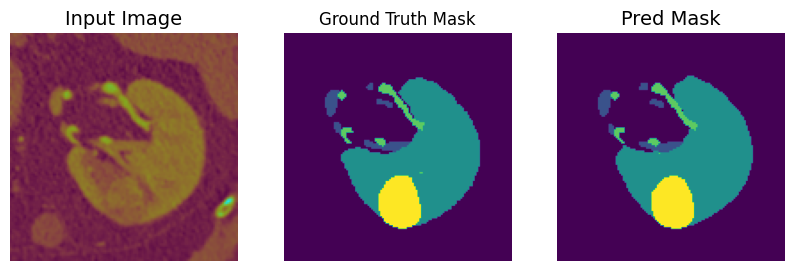

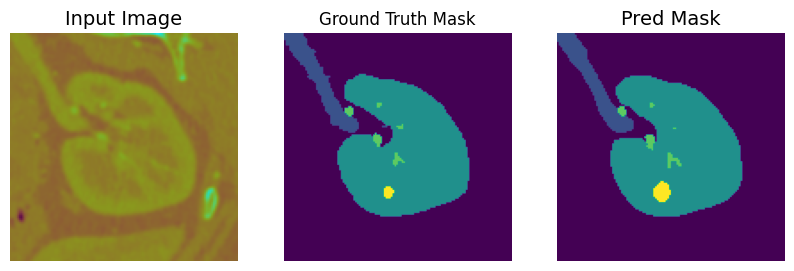

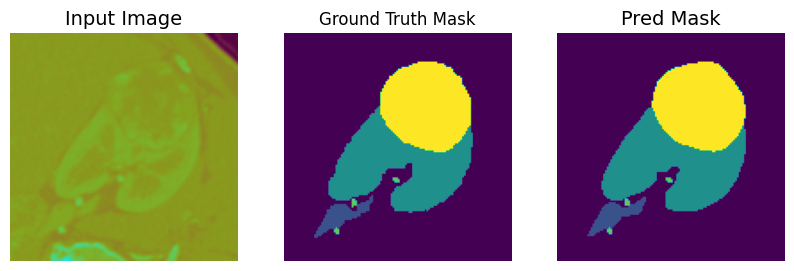

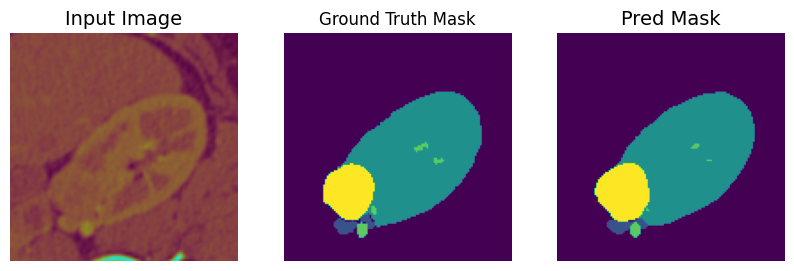

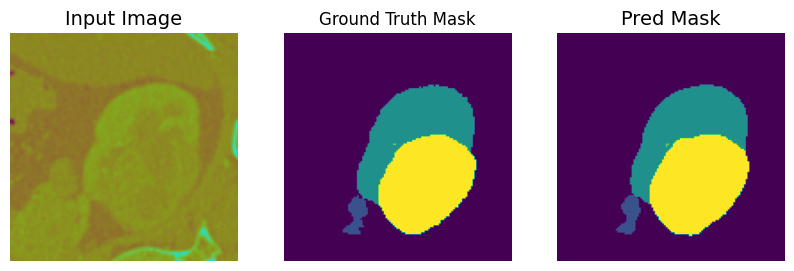

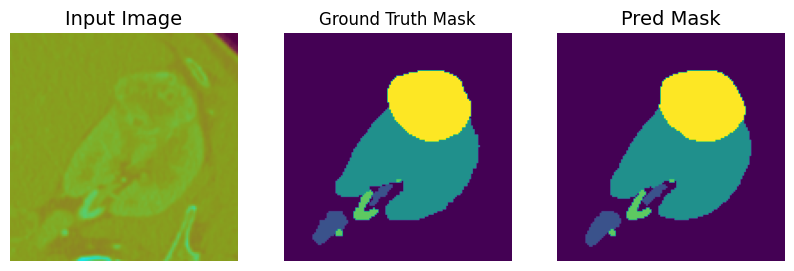

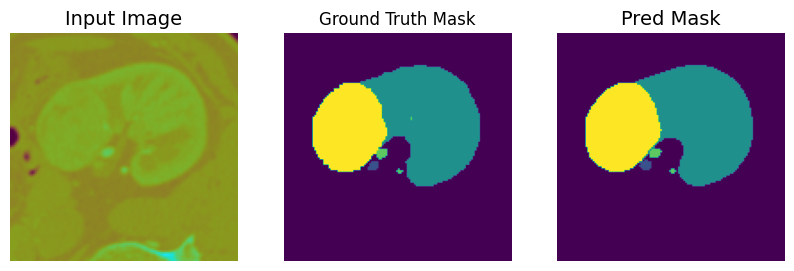

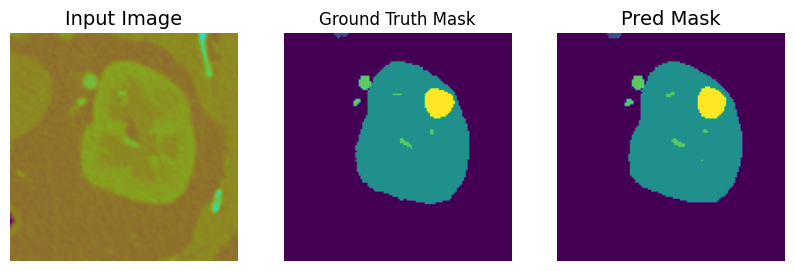

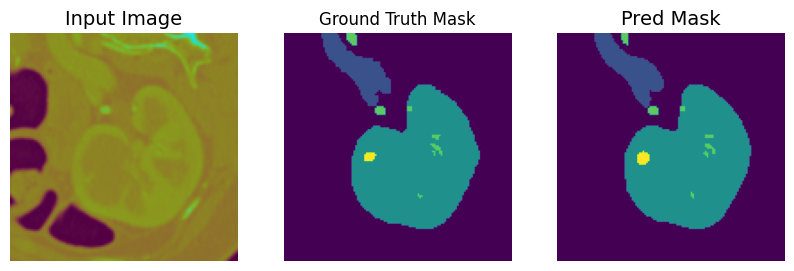

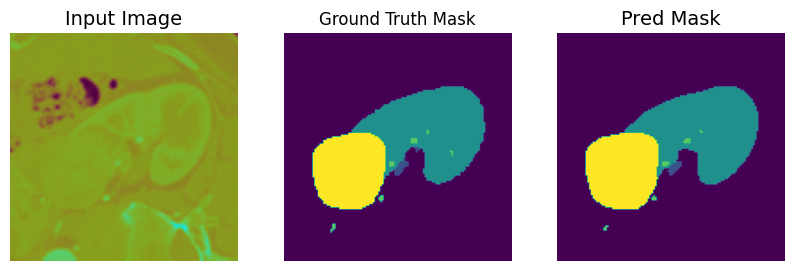

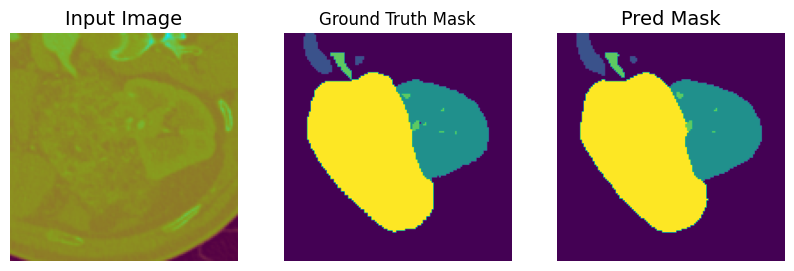

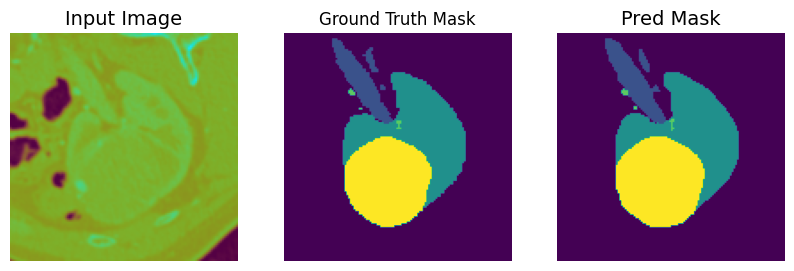

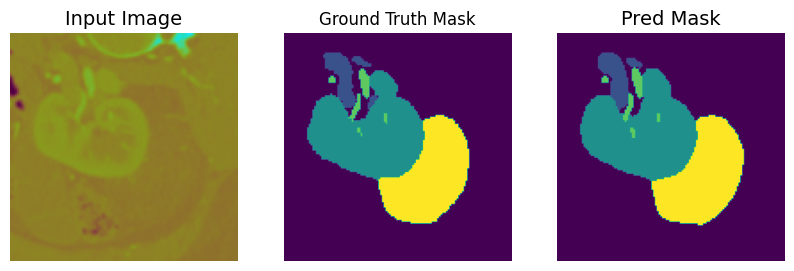

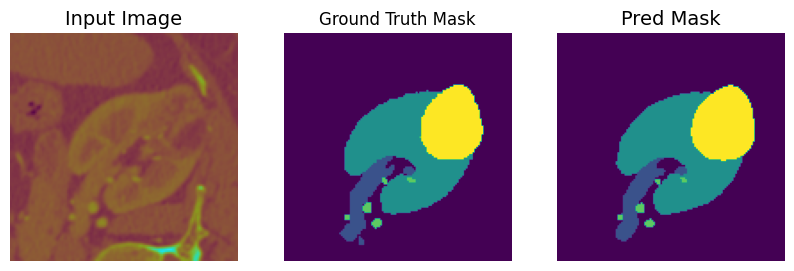

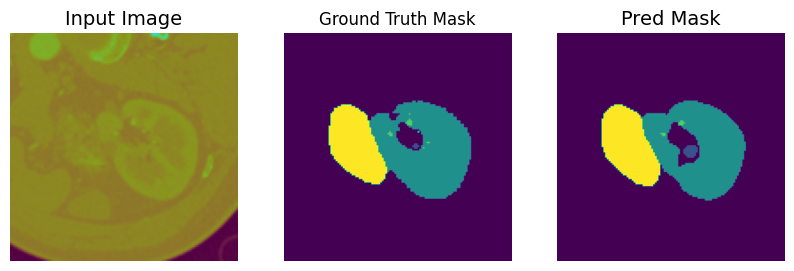

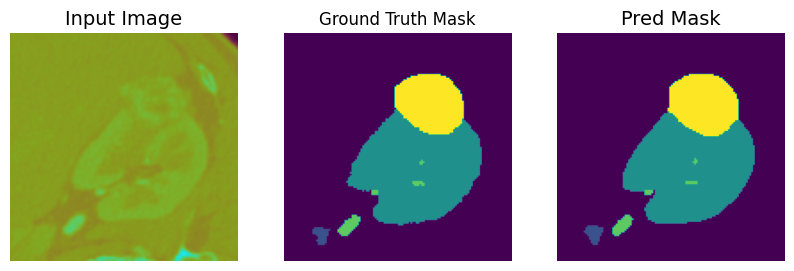

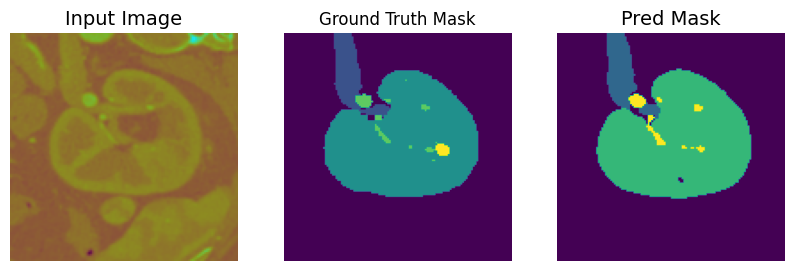

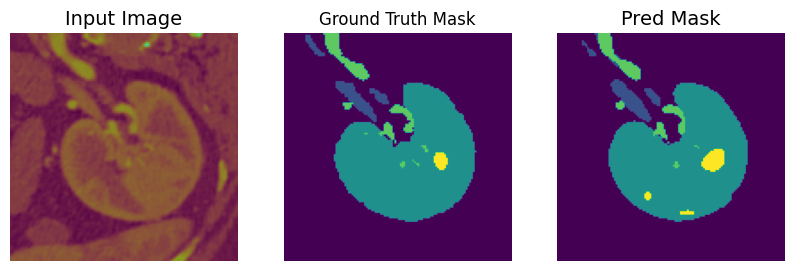

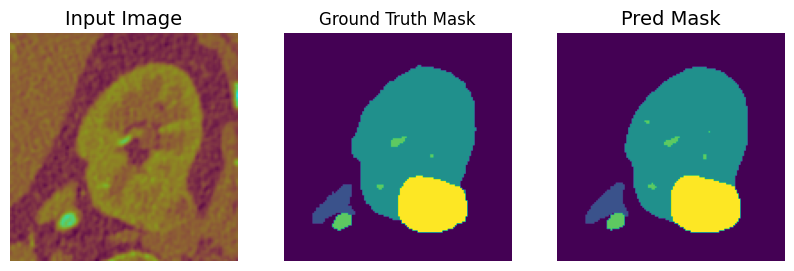

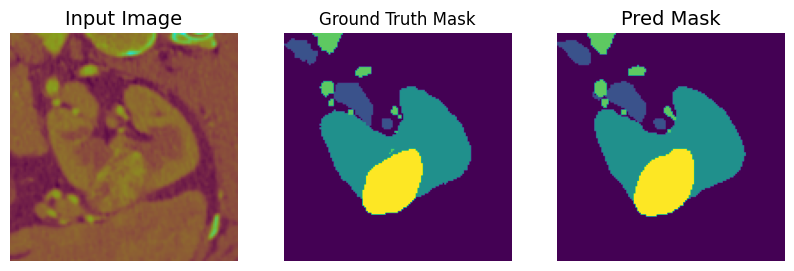

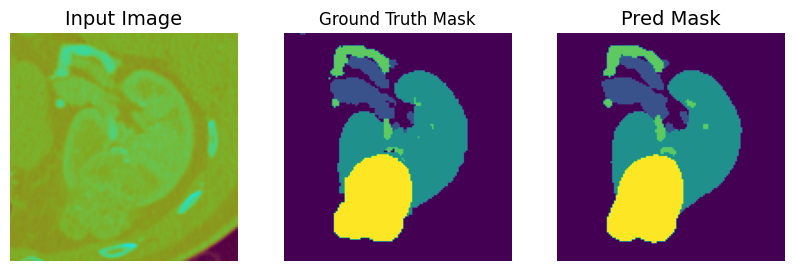

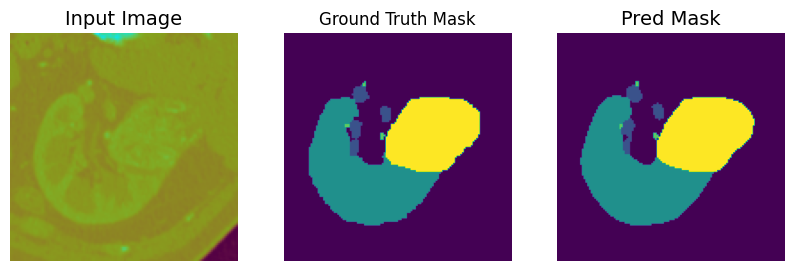

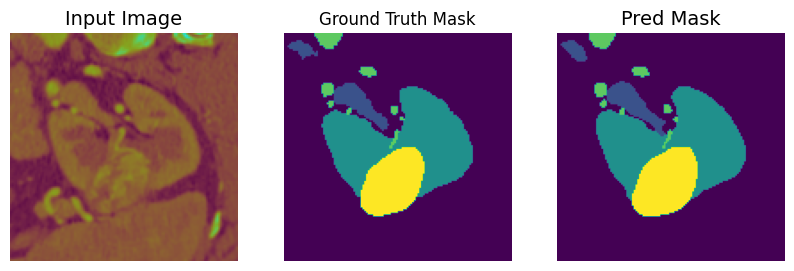

In [21]:
for i in range(0,25):
    plt.figure(figsize=(10,10))
    plt.axis('Off')
    test_image = x_test[i, :, :]
    plt.subplot(1,3,1)
    plt.imshow(test_image)
    plt.title('Input Image', fontsize=14)
    plt.axis('off')

    test_mask=y_test[i,:,:]
    plt.subplot(1,3,2)
    plt.imshow(test_mask)
    plt.title('Ground Truth Mask')
    plt.axis('off')

    test_mask = preds_test_thresh[i, :, :]
    plt.subplot(1,3,3)
    plt.imshow(test_mask)
    plt.title('Pred Mask', fontsize=14)
    plt.axis('off')

In [17]:
model.save('kidney 2d segmentation model.h5')

In [19]:
from skimage.measure import regionprops_table, label, regionprops
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [84]:
out=regionprops_table(y_test[0],properties=['area'])
out=pd.DataFrame(out)
out

,area
0,346.0
1,2383.0
2,24.0
3,1217.0


In [85]:
out1=regionprops_table(preds_test_thresh[0],properties=['area'])
out1=pd.DataFrame(out1)
out1

,area
0,346.0
1,2410.0
2,28.0
3,1210.0


In [136]:
props_a=[]
props_b=[]
for k,l in zip(y_train,preds_train_thresh):
    a=regionprops_table(k,properties=['area'])
    b=regionprops_table(l,properties=['area'])
    props_a.append(a)
    props_b.append(b)

In [137]:
pp=pd.DataFrame(props_a)
pp

,area
0,"[513.0, 2796.0, 347.0, 756.0]"
1,"[52.0, 2187.0, 41.0, 2514.0]"
2,"[161.0, 3060.0, 143.0, 168.0]"
3,"[30.0, 2837.0, 43.0, 1698.0]"
4,"[250.0, 3597.0, 70.0, 13.0]"
...,...
1616,"[299.0, 3413.0, 59.0, 2096.0]"
1617,"[18.0, 2622.0, 79.0, 1916.0]"
1618,"[49.0, 2546.0, 115.0, 2154.0]"
1619,"[87.0, 1498.0, 9.0, 4538.0]"


In [138]:
qq=pd.DataFrame(props_b)
qq

,area
0,"[527.0, 2793.0, 288.0, 783.0]"
1,"[36.0, 2224.0, 38.0, 2519.0]"
2,"[141.0, 3043.0, 74.0, 225.0]"
3,"[38.0, 2869.0, 45.0, 1747.0]"
4,"[258.0, 3673.0, 76.0, 7.0]"
...,...
1616,"[288.0, 3432.0, 52.0, 2133.0]"
1617,"[16.0, 2628.0, 76.0, 1950.0]"
1618,"[43.0, 2571.0, 107.0, 2186.0]"
1619,"[100.0, 1519.0, 8.0, 4568.0]"


In [139]:
pp=pp.loc[:,'area']
qq=qq.loc[:,'area']

In [140]:
iou0=[]
iou1=[]
iou2=[]
iou3=[]
for i,j in zip(pp,qq):
    try:
        iou_0=min(int(i[0]),int(j[0]))/max(int(i[0]),int(j[0]))
        iou_1=min(int(i[1]),int(j[1]))/max(int(i[1]),int(j[1]))
        iou_2=min(int(i[2]),int(j[2]))/max(int(i[2]),int(j[2]))
        iou_3=min(int(i[3]),int(j[3]))/max(int(i[3]),int(j[3]))
        iou0.append(iou_0)
        iou1.append(iou_1)
        iou2.append(iou_2)
        iou3.append(iou_3)
    except:
        continue

In [141]:
print('artery',np.mean(iou0))
print('kidney',np.mean(iou1))
print('vein',np.mean(iou2))
print('tumor',np.mean(iou3))

artery 0.9315245431587004
kidney 0.9868453358120073
vein 0.8988002121891444
tumor 0.9456293004079558
